In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import torch

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from IPython.display import clear_output

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. Data
## 1.1 Loading and splitting features

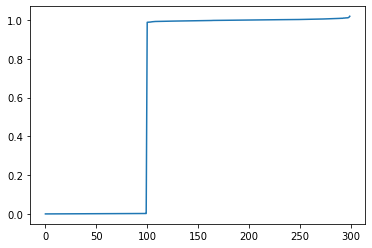

In [10]:
full_data = pd.read_csv("data/train.csv", index_col='Id')
testdata = pd.read_csv("data/test.csv", index_col='Id')

x_train_raw, y_train_raw = full_data.drop(columns=["Category"]), full_data.Category

indicies_sorted = np.argsort(x_train_raw.var())

x_train_raw = x_train_raw.to_numpy()[:, indicies_sorted]
x_test_raw = testdata.to_numpy()[:, indicies_sorted]
y_train_raw = y_train_raw.to_numpy() >= 0 # in order y to act like a distribution. DO NOT FORGET TO CHANGE IT!

plt.plot(np.var(x_train_raw, axis=0))

In [53]:
N_WHITE = 100

## 1.2 Preprocessing

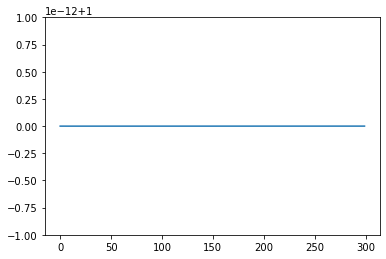

In [11]:
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train_raw, )
x_test = scaler.transform(x_test_raw)

plt.plot(np.var(x_train, axis=0))

# 2. Model side
## 2.1 Functional

In [69]:
def train_epoch(model, x_train, y_train, criterion, optimizer, batch_size=64, batches_per_epoch=10):
    model.train()
    
    loss_history = []
    train_size = x_train.shape[0]
    
    for n_batch in range(batches_per_epoch):
        
        optimizer.zero_grad()
        
        
        batch_ids = np.random.choice(train_size, batch_size)
        
        x_batch, y_batch = x_train[batch_ids], y_train[batch_ids]
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        output = model(x_batch)
        loss = criterion(output, y_batch)
        
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.data.cpu().numpy())
    
    return loss_history
             
        
def predict_proba(model, x_test, batch_size=64):
    model.eval()
    test_dataset = torch.utils.data.TensorDataset(x_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    
    pred = []
    
    for x_batch in test_loader:
        x_batch = x_batch[0].to(device)
        
        logits = model(x_batch) # [batch_size, 1]
        probas = torch.sigmoid(logits).data.cpu().numpy()
        
        pred.extend(probas)
        
    return np.array(pred)
    
def train_model(model, x_train, y_train, criterion, optimizer, n_epochs, batch_size, batches_per_epoch, x_val=None, y_val=None, threshold=0.5, log_best=False, name="model"):
    train_loss_history = []
    acc_history = []
    
    for epoch in range(n_epochs):
        loss = train_epoch(model, x_train, y_train, criterion, optimizer, batch_size=batch_size, batches_per_epoch=batches_per_epoch)
        train_loss_history.extend(loss)
        
        if (x_val is not None) and (y_val is not None):
            preds = predict_proba(model, x_val, batch_size=batch_size) >= threshold
            acc = np.mean(preds == y_val.numpy())
            acc_history.append(acc)
            
            
        # printing
        
        clear_output(True)        
        plt.subplots(1, 2, figsize=(20, 10))
        
        plt.subplot(1, 2, 1)
        plt.plot(train_loss_history)
    
        plt.subplot(1, 2, 2)
        if acc_history is not None:
            plt.plot(acc_history)
            
            
            
            
        print("Epoch {}: train loss={:.5f}".format(epoch, loss[-1]))
        print("Val acc = {:.3f}, Best = {:.3f}".format(acc_history[-1], max(acc_history)))
        
        time.sleep(0.01)
        plt.pause(0.0001)
        
        if log_best:
            torch.save(model.state_dict(), r"models/" + name + "_best_val.pth")

In [ ]:
class Perceptron(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device

    def __init__(self, input_dim=300, num_layers=0, 
                 hidden_dim=100, output_dim=1, p=0.0):
        super(Perceptron, self).__init__()
        
        self.layers = torch.nn.Sequential()
        
        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i), 
                                  torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
            prev_size = hidden_dim
        
        self.layers.add_module('classifier', 
                               torch.nn.Linear(prev_size, output_dim))        
        
    def forward(self, input):
        return self.layers(input)

Проведем простой тест, обучив обычный перцептрон:

In [23]:
# Data preparation

X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train_raw, test_size=0.2)

X_train = torch.Tensor(X_train)
Y_train = torch.FloatTensor(Y_train).unsqueeze(1)

X_val = torch.Tensor(X_val)
Y_val = torch.FloatTensor(Y_val).unsqueeze(1)

Epoch 19: train loss=0.001
Val acc = 0.960, Best = 0.962


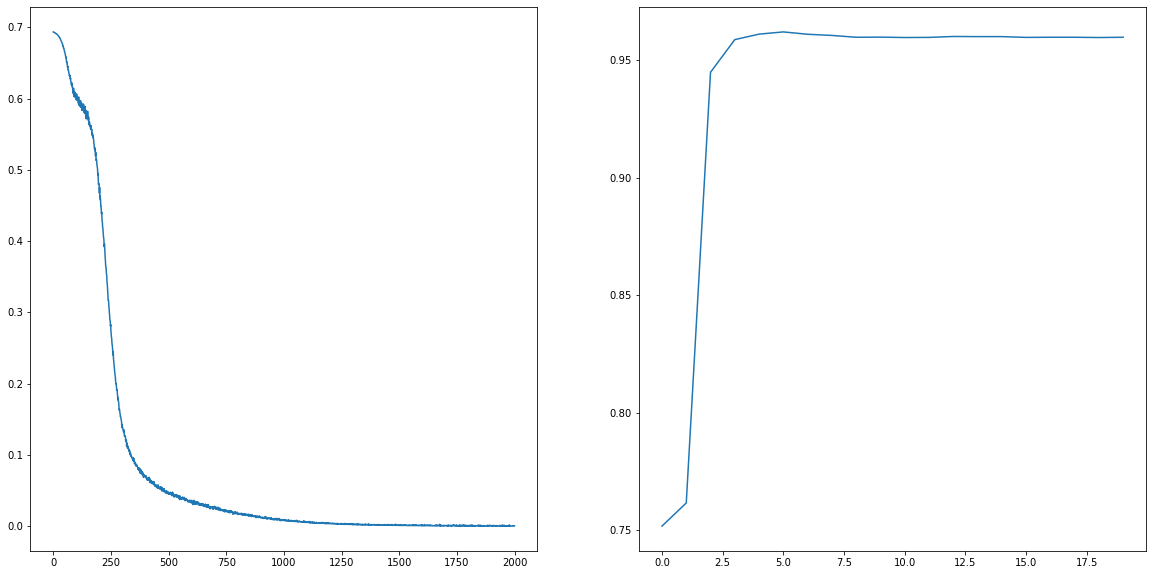

In [24]:
model = Perceptron(num_layers=4, hidden_dim=100).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_model(model, X_train, Y_train, torch.nn.BCEWithLogitsLoss(), optimizer, n_epochs=20, batch_size=16384, batches_per_epoch=100, x_val=X_val, y_val=Y_val)

## 2.2 Actually model

In [47]:
class ResBlock1D(torch.nn.Module):
    def __init__(self, hid_dim):
        super(ResBlock1D, self).__init__()
        
        self.fc_1 = torch.nn.Linear(hid_dim, hid_dim)
        self.relu_1 = torch.nn.ReLU()
        self.fc_2 = torch.nn.Linear(hid_dim, hid_dim)
        self.relu_2 = torch.nn.ReLU()
    
    def forward(self, in_vectors):
        hid_state = self.relu_1(self.fc_1(in_vectors))
        hid_state = self.relu_2(self.fc_2(hid_state))
        
        return hid_state + in_vectors
    
class Encoder(torch.nn.Module):
    def __init__(self, enc_name, enc_input_dim, enc_hid_dim, enc_n_layers):
        super(Encoder, self).__init__()
        assert enc_name is not None
        
        self.encoder = torch.nn.Sequential()
        
        # gate block
        self.encoder.add_module(enc_name + "_gate_linear", torch.nn.Linear(enc_input_dim, enc_hid_dim))
        self.encoder.add_module(enc_name + "_gate_bn", torch.nn.BatchNorm1d(enc_hid_dim))
        self.encoder.add_module(enc_name + "_gate_relu", torch.nn.ReLU())
        
        # tail
        for i in range(enc_n_layers):
            self.encoder.add_module(enc_name + f"_res_block_{i + 1}",
                                   ResBlock1D(enc_hid_dim))
            
    def forward(self, in_vectors):
        return self.encoder(in_vectors)
            
class Decoder(Encoder):
    def __init__(self, dec_name, dec_input_dim, dec_hid_dim, dec_n_layers):
        super(Decoder, self).__init__(dec_name, dec_input_dim, dec_hid_dim, dec_n_layers)
        
        self.classifier = torch.nn.Linear(dec_hid_dim, 1)
        
    def forward(self, in_vectors):
        hid_state = self.encoder(in_vectors)
        
        return self.classifier(hid_state)

In [48]:
dec = Decoder("my_dec", 100, 50, 3)
dec

Decoder(
  (encoder): Sequential(
    (my_dec_gate_linear): Linear(in_features=100, out_features=50, bias=True)
    (my_dec_gate_bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (my_dec_gate_relu): ReLU()
    (my_dec_res_block_1): ResBlock1D(
      (fc_1): Linear(in_features=50, out_features=50, bias=True)
      (relu_1): ReLU()
      (fc_2): Linear(in_features=50, out_features=50, bias=True)
      (relu_2): ReLU()
    )
    (my_dec_res_block_2): ResBlock1D(
      (fc_1): Linear(in_features=50, out_features=50, bias=True)
      (relu_1): ReLU()
      (fc_2): Linear(in_features=50, out_features=50, bias=True)
      (relu_2): ReLU()
    )
    (my_dec_res_block_3): ResBlock1D(
      (fc_1): Linear(in_features=50, out_features=50, bias=True)
      (relu_1): ReLU()
      (fc_2): Linear(in_features=50, out_features=50, bias=True)
      (relu_2): ReLU()
    )
  )
  (classifier): Linear(in_features=50, out_features=1, bias=True)
)

In [51]:
dec(torch.randn(53, 100)).shape

torch.Size([53, 1])

In [55]:
class BlackWhiteNet(torch.nn.Module):
    def __init__(self, white_input_dim, white_hid_dim, white_n_layers,  black_input_dim, black_hid_dim, black_n_layers, dec_hid_dim, dec_n_layers):
        super(BlackWhiteNet, self).__init__()
        
        self.white_encoder = Encoder("white_encoder", white_input_dim, white_hid_dim, white_n_layers)
        self.black_encoder = Encoder("black_encoder", black_input_dim, black_hid_dim, black_n_layers)
        
        self.decoder = Decoder("decoder", white_hid_dim + black_hid_dim, dec_hid_dim, dec_n_layers)
        
    def forward(self, in_features):
        white_features = in_features[:, :N_WHITE]
        black_features = in_features[:, N_WHITE:]
        
        white_hid_state = self.white_encoder(white_features)
        black_hid_state = self.black_encoder(black_features)
        
        hid_state = torch.cat((white_hid_state, black_hid_state), dim=1)
        
        return self.decoder(hid_state)

In [101]:
params = {
    "white_input_dim": 100,
    "white_hid_dim": 15,
    "white_n_layers": 4,
    "black_input_dim": 200,
    "black_hid_dim": 20,
    "black_n_layers": 2,
    "dec_hid_dim": 25,
    "dec_n_layers": 4
}

baseline = BlackWhiteNet(**params).to(device)
optimizer = torch.optim.Adam(baseline.parameters(), lr=1e-4)

In [105]:
pytorch_total_params = sum(p.numel() for p in baseline.parameters() if p.requires_grad)
pytorch_total_params

15381

Epoch 26: train loss=0.00218
Val acc = 0.963, Best = 0.965


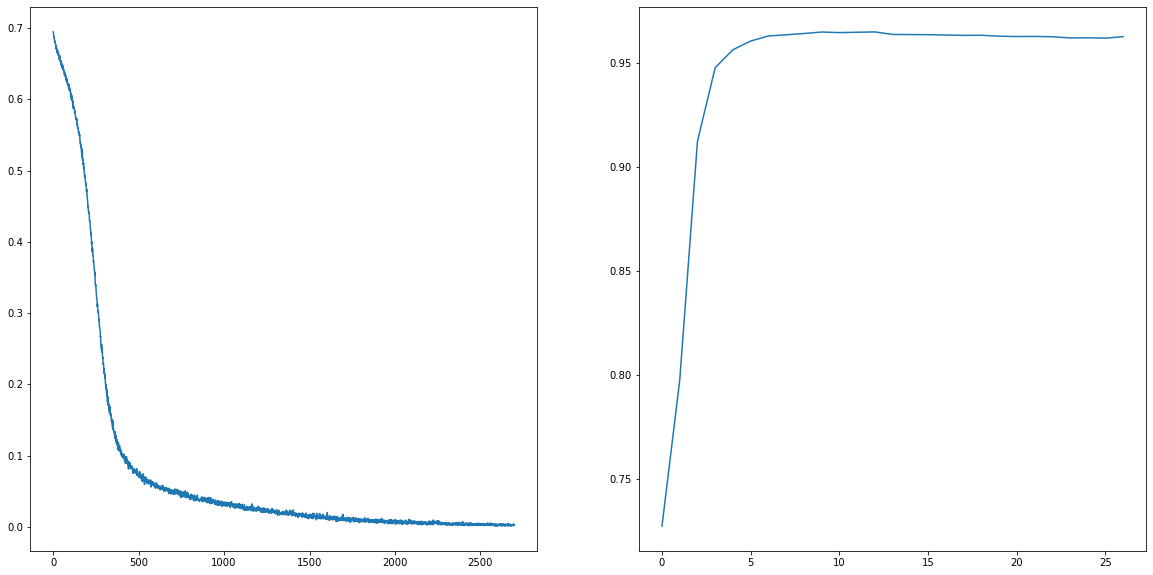

KeyboardInterrupt: 

In [102]:
train_model(baseline,
            X_train, Y_train,
            torch.nn.BCEWithLogitsLoss(), optimizer,
            n_epochs=100, batch_size=16384, batches_per_epoch=100,
            x_val=X_val, y_val=Y_val, 
            log_best=True, name="baseline")

In [70]:
torch.save(baseline.state_dict(), "models/baseline_100.pth")

## 2.3 Generate first submission

In [95]:
baseline.load_state_dict(torch.load("models/baseline_best_val"))

def predict(model, x_test, batch_size=64, threshold=0.5):
    probas = predict_proba(model, x_test, batch_size=batch_size)
    return np.where(probas >= threshold, np.array(1), np.array(-1))

def generate_submission(model, threshold=0.5):
    X_test = torch.Tensor(x_test)
    labels = predict(model, X_test)
    
    table = pd.DataFrame(index=testdata.index)
    table['Category'] = labels
    submission_name = time.strftime("%a_%d_%H_%M",time.localtime()) + ".csv"
    
    table.to_csv("submissions/" + submission_name)

In [96]:
# generate_submission(baseline)